# Entanglement Generation

A useful feature of ZPGenerator to solving photon counting problems is that it can also provide the state of the source conditioned on time-integrated detection outcomes, in addition to raw detection probability. This is allows the package to be used to study protocols that encode quantum information in the state of the source. In this tutorial, we will explore the conditional states feature in order to estimate the quality of photon-mediated entanglement generation between spin qubits situated in spatially-separated emitters. Following the structure of [[S. C. Wein et al., Phys. Rev. A 102, 033701 (2020)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.033701)], we will delve into three different protocols each based on a different encoding in the pulse of light: (1) photon-number encoding, (2) time-bin encoding, (3) and polarization encoding. To demonstrate these protocols, we will use the Source.trion() source type, which is introduced in the third section of ex_quantum_dots.ipynb.

## Photon-number encoding

This scheme for generating entanglement between remote spin qubits relies on first entangling the spin degree of freedom with the number of emitted photons (either 0 or 1). In other words, the goal is to produce a state of the form $|\psi\rangle = (|\downarrow\rangle |0\rangle + |\uparrow\rangle |1\rangle)/\sqrt{2}$ from each of two different emitters. The pulse of light is then sent through a beam splitter that is monitored by photon-number resolving detectors. If exactly one detector detects exactly one photon, then the which-path information of the incoming photon is erased and the two spin qubits are projected onto a maximally entangled Bell state. Let's set up this experiment using the ZPG package.

In [92]:
from zpgenerator import *
import numpy as np
import qutip  as qt
import matplotlib.pyplot as plt

First thing to do is create our trion quantum dot source. By default, the trion initial state is a maximally mixed state between the spin up anda spin down states. To produce entanglement, we can initialize our trion into a superposition state. A more realistic simulation might explicitly simulate this state preparation step, as was shown in the [Quantum Dots](quantum_dots.ipynb) tutorial.

In [93]:
trion = Source.trion()
trion.initial_state = (trion.states['|spin_up>'] + trion.states['|spin_down>']) / np.sqrt(2)

To produce the entangled state, we can drive our source with a $\pi$ pulse to excite the $|\uparrow\rangle$ state so that it produces an R-polarized photon. To ensure this behaviour, we can update the default parameters of the source so that the excitation and collection angles are both circularly polarized.

In [94]:
trion.update_default_parameters({'theta': np.pi/4, 'phi': -np.pi/2, # excitation polarization: right circular polarized.
                                 'theta_c': np.pi/4, 'phi_c': -np.pi/2, # collect polarization: right mode 0 (left for mode 1)
                                 'area': np.pi})  # pulse area of pi to bring the spin up state fully to the trion state

Now that we have created our source, we can build our optical setup using the Processor class. Recall that the trion source has two emission modes: a right-polarized emission and a left-polarized emission by default. So, we can add our trion source to modes 0 and 2 of our processor, so that the polarization assignment will be: 0 - Right, 1 - Left, 2 - Right, 3 - Left.

In [95]:
p = Processor() // ([0, 2], trion)

We can check to ensure that our excitation and collection parameters are correct by seeing if modes 0 and 2 each show a probability of 1/2 to emit a photon while modes 1 and 3 are empty.

In [96]:
for m in range(4):
    print('Mode ' + str(m))
    p.photon_statistics(port=m, truncation=2).display()

Mode 0
Number  | Probability
0       | 0.50000
1       | 0.50000
2       | 0.00000

Mode 1
Number  | Probability
0       | 1.00000
1       | 0.00000
2       | 0.00000

Mode 2
Number  | Probability
0       | 0.50000
1       | 0.50000
2       | 0.00000

Mode 3
Number  | Probability
0       | 1.00000
1       | 0.00000
2       | 0.00000



To generate entanglement between the two emitters, we must pass the emission from modes 0 and 2 through each input of a balanced beamsplitter. To do this, we can permute the modes so that modes 0 and 2 are beside each other, then add our beamsplitter. Let's also add a beam splitter on the orthogonal polarization mode and permute the modes back, so that the entire component can represent a single beam splitter serving as an entangling circuit.

In [97]:
entangling_circuit = Circuit.perm([0, 2, 1, 3]) // (0, Circuit.bs()) // (2, Circuit.bs()) // Circuit.perm([0, 2, 1, 3])
detectors = ([0, 2], Detector.pnr(2))
p = p // entangling_circuit // detectors

Now that we have defined our optical setup, we can simulate all the conditional states of the processor using the conditional_states() method of the Processor class. This produces a dictionary of Qobj density operators that represent the unnormalized state of the two trion sources conditioned on the photo-detection pattern represented by the dictionary key of a tuple of integers. Please see the [QuTiP Documentation](https://qutip.org/docs/latest/) for more information about Qobj objects.

Notice that, since the final time is by default much longer than the system emission timescale, all the conditional states have negligible population in the source excited state. Since we care only about the spin qubit in the ground state, we can take a partial trace of our states to eliminate the excited state manifolds. This can be done using QuTiP's ptrace function, or we can simply specify the desired subspaces when simulating the conditional states using the 'select' keyword, which simply applies the ptrace function before returning the results. In this case, note that the first index of the trion source labels the $|g\rangle$, $|e\rangle$ states while the second index of the trion source is the spin qubit. Adding the two sources to the processor concatenates these spaces, so that the desired subspace is the second and fourth indices (labeled 1 and 3). After tracing out the excited states, we can then ask for the state associated with the detection outcome (1, 0), where we observed exactly one photon at the first detector and zero photons at the second. If everything goes well, this should be an entangled state.

In [98]:
states = p.conditional_states(select=[1, 3])
states[1, 0].tidyup(1e-6)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j   ]
 [0.   +0.j    0.125+0.j    0.   -0.125j 0.   +0.j   ]
 [0.   +0.j    0.   +0.125j 0.125+0.j    0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.   +0.j    0.   +0.j   ]]

Indeed, we can see that we have an entangled state. However, the density operator is not normalized because the probability of outcome (1, 0) is not unity. We can simply re-normalize this operator by its trace and then use QuTiP's concurrence function to check how entangled it is.

In [99]:
qt.concurrence(states[1, 0] / states[1, 0].tr())

0.9999999925450656

As we can see, the entanglement concurrence of the spin qubit state is unity within precision of the simulation (default 6 digits), given that the outcome (1, 0) was observed. However, note that the efficiency of our setup defaults to 100%, meaning that no photons are lost. Having a protocol that is robust against loss is extremely important since it is extremely difficult to eliminate loss entirely. Let's create a new optical setup that has some loss in between the sources and the entangling circuit.

In [100]:
p_num = Processor() // ([0, 2], trion) // Circuit.loss(modes=4, name='transmission') // entangling_circuit // detectors

transmission_list = np.linspace(0.01, 1, 20)
state_list = [p_num.conditional_states(parameters={'transmission/efficiency': eff}, select=[1, 3]) for eff in transmission_list]

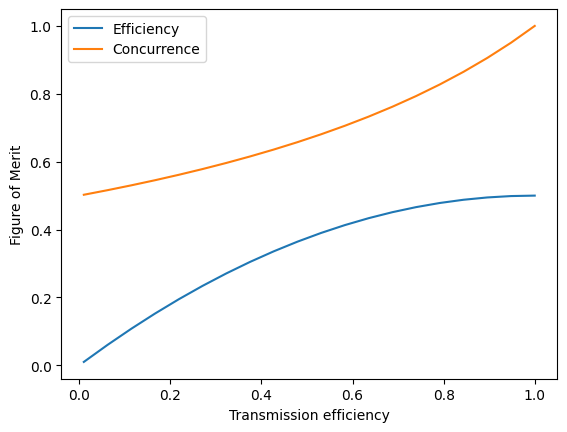

In [101]:
efficiency_list = [abs(2 * states[1, 0].tr()) for states in state_list]  # multiply by 2 for both successful outcomes (assuming symmetry)
concurrence_list = [qt.concurrence(states[1, 0] / states[1, 0].tr()) for states in state_list]
plt.plot(transmission_list, efficiency_list, label='Efficiency')
plt.plot(transmission_list, concurrence_list, label='Concurrence')
plt.xlabel('Transmission efficiency')
plt.ylabel('Figure of Merit')
plt.legend()
plt.show()

From this plot, we can see that the entanglement concurrence of the resulting state rapidly degrades with a decreasing transmission efficiency, along with the total efficiency of the protocol. The reason why this happens is that if both trion emitters produce a photon (i.e. end up in the $|\uparrow\rangle|\uparrow\rangle$ state), a single lost photon can result in a (1, 0) outcome and cause infidelity. To compensate for this problem, the solution is to reduce the probability the trions produce photons by biasing the initial state to be in the $|\downarrow\rangle$ state. That is, we make the initial state $|\psi\rangle =  \sin(\vartheta)|\uparrow\rangle + \cos(\vartheta)|\downarrow\rangle$ where $\vartheta$ is close to 0 when transmission efficiency is small.

In [102]:
angles = np.linspace(0.01, 0.5, 20)
state_list = []
trion_num = trion  # since we will modify this object and overwrite it later, let's rename it
for theta in angles:
    trion_num.initial_state = np.sin(theta * np.pi) * trion.states['|spin_up>'] + np.cos(theta * np.pi) * trion.states['|spin_down>']
    state_list.append(p_num.conditional_states(parameters={'transmission/efficiency': 0.5}, select=[1, 3]))

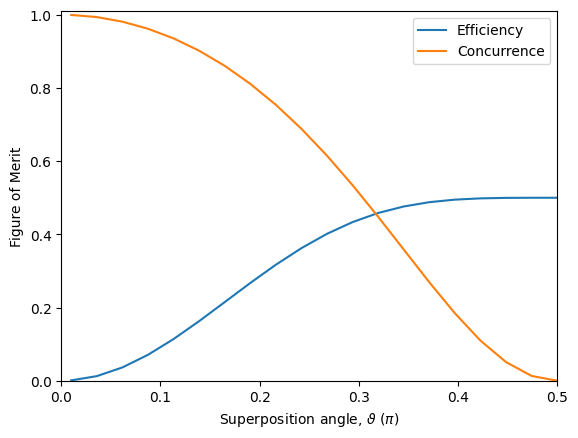

In [103]:
efficiency_list = [abs(2 * states[0, 1].tr()) for states in state_list]
concurrence_list = [qt.concurrence(states[0, 1]/states[0, 1].tr()) for states in state_list]
plt.plot(angles, efficiency_list, label='Efficiency')
plt.plot(angles, concurrence_list, label='Concurrence')
plt.xlabel('Superposition angle, $\\vartheta$ ($\pi$)')
plt.ylabel('Figure of Merit')
plt.ylim([0, 1.01])
plt.xlim([0, 0.5])
plt.legend()
plt.show()

Now we can see that, by reducing the probability of producing light, we can sacrifice efficiency to arbitrarily bring the concurrence near unity in this idealized scenario. Although it may seem counterintuitive, it turns out that this encoding can provide a significant efficiency advantage over the other two encodings despite having to sacrifice emission probability to achieve high fidelity entanglement [[S. C. Wein et al., Phys. Rev. A 102, 033701 (2020)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.033701), [S. L. N. Hermans et al., New J. Phys. 25, 013011 (2023)](https://iopscience.iop.org/article/10.1088/1367-2630/acb004/meta)].

## Time-bin encoding

As we saw in the previous example, the photon-number encoding is sensitive to loss. In addition, it is a method that is sensitive to phase instability in the photon routing. One approach to combat these downsides was proposed by S. D. Barrett and P. Kok in 2005 [[S. D. Barrett and P. Kok, Phys. Rev. A 71, 060310(R) (2005)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.71.060310)]. This method uses the emission time bin to encode the quantum information rather than the number of emitted photons, and it was famously implemented in the first demonstration of a loop-hole free Bell inequality violation [[B. Hensen et al., Nature 526, 682-686 (2015)](https://www.nature.com/articles/nature15759)].

The time-bin encoding follows very similarly to the photon-number encoding. However, instead of ending the protocol after the detection of a single photon, the spin state of both sources are flipped and then the photon-number protocol is repeated a second time. If a single photon is detected both before and after the spin flip, this implies that no photons were lost and the spin states are projected onto a maximally entangled state regardless of losses. In addition, the flip-and-repeat approach creates a symmetry so that exactly one photon must have travelled from each source, which naturally eliminates any phase instability.

To demonstrate this scheme, we will use the same trion source as in the previous section. However, this time we will give a more complicated pulse sequence that will attempt two photon-number encoding protocols separated by a spin flip. This will require us to modify our source to add a control on the spin qubit. To make things easier, we can also use the operators available from the TrionEmitter object contained in the trion source.

In [104]:
# make a sequence of two dirac pulses with different names so that we can modify their parameters independently
excitation_sequence = Pulse(name='excitation')
excitation_sequence.add(Pulse.dirac(parameters={'delay': 0}, name='first'))
excitation_sequence.add(Pulse.dirac(parameters={'delay': 20}, name='second'))

# create the catalogue trion source component using the excitation sequence
trion = Source.trion(pulse=excitation_sequence)

# we can extract the emitter object contained in the source component to modify it
emitter = trion.elements['_TrionEmitter']

# using the Control class method 'drive', we create a new control object to drive a specified transition of the emitter using a dirac pulse
spin_control = Control.drive(pulse=Pulse.dirac(parameters={'delay': 18}, name='spin control'),
                             transition=emitter.states['|spin_down>'] * emitter.states['|spin_up>'].dag())
emitter.add(spin_control)

# as before, we initialize the trion into a superposition state, and specify the default excitation parameters
trion.initial_state = (trion.states['|spin_up>'] + trion.states['|spin_down>']) / np.sqrt(2)
trion.update_default_parameters({'theta': np.pi/4, 'phi': -np.pi/2, 'theta_c': np.pi/4, 'phi_c': -np.pi/2})

Now that we have our source, we can build our processor as we did in the previous section. Before doing that, we must construct the detector needed to monitor two time bins of the same spatial mode. This can be done using the partition class method of the Detector class. Please see [Detectors](detectors.ipynb) for more information about this detector type. Since we expect at most two photons overall using this pulse sequence, we can specify a photon number resolution of 2. To help distinguish the photon indices, we can also make an argument to name the detector.

In [105]:
time_bin_detector = lambda name: Detector.partition(['excitation/first/delay', 'excitation/second/delay'], # first bin goes from the first pulse to the second, the second bin goes from the second pulse to infinity
                                                    parameters={'excitation/first/delay': 0, 'excitation/second/delay': 20},  # default parameters to match previous defaults
                                                    resolution=2,
                                                    name=name)

To make sure our source and detectors are configured correctly, we can ensure that we get 1/2 probability of seeing a photon in the first time bin and 1/2 probability of seeing a photon in the second time bin.

In [106]:
p = Processor() // trion // time_bin_detector('detector')
print(p.bin_labels)
p.probs().display()

['detector bin 0', 'detector bin 1']
Pattern | Probability
1 0     | 0.50000
0 1     | 0.50000



Now that we have verified that our source and detectors are operating correctly, we can build the entanglement setup. To distinguish time bins in each spatial mode, we can name the detectors 'left' and 'right' that are monitoring modes 0 and 1, respectively.

In [107]:
p = Processor() // ([0, 2], trion) // entangling_circuit // (0, time_bin_detector('left')) // (2, time_bin_detector('right'))
print(p.bin_labels)
p.probs().display()

['left bin 0', 'left bin 1', 'right bin 0', 'right bin 1']
Pattern | Probability
2 0 0 0 | 0.12500
1 1 0 0 | 0.12500
0 2 0 0 | 0.12500
0 1 1 0 | 0.12500
0 0 2 0 | 0.12500
1 0 0 1 | 0.12500
0 0 1 1 | 0.12500
0 0 0 2 | 0.12500



We can now see all the detection outcomes expected of the scheme in the ideal case. Notice that we always observe exactly two photons, and importantly it is the two-photon outcomes that now herald the successful projection of the spins onto an entangled state. This means that loss or number-resolving limitations cannot cause errors. Notice also that we never observe outcomes like (1, 0, 1, 0,) and (0, 1, 0, 1), since these are eliminated due to perfect Hong-Ou-Mandel interference between photons from the two sources. Once we start adding imperfections, like decoherence, these cases can appear.

Now that we have verified our outcome probabilities are correct, let's take a look at the entanglement concurrence of the spin state of the source conditioned on each outcome.

In [108]:
states = p.conditional_states(select=[1, 3])
for pattern, state in states.items():
    print(pattern, qt.concurrence(state / state.tr()))

(0, 0, 0, 2) 0
(0, 2, 0, 0) 0
(0, 0, 1, 1) 0.9999882077603706
(0, 1, 1, 0) 0.9999973704435464
(0, 0, 2, 0) 0
(1, 0, 0, 1) 0.9999973775122543
(1, 1, 0, 0) 0.9999882133082519
(2, 0, 0, 0) 0


As expected, if we observe exactly one photon in both the first time bin (in either spatial mode) and exactly one photon in the second time bin (in either spatial mode), we generate a maximally entangled spin state up to the simulation precision. Now, as before, we can test how robust the scheme is to transmission losses.

In [109]:
p_time = Processor() // ([0, 2], trion) // Circuit.loss(modes=4, name='transmission') // entangling_circuit // (0, time_bin_detector('left')) // (2, time_bin_detector('right'))
transmission_list = np.linspace(0.01, 1, 20)
state_list = [p_time.conditional_states(parameters={'transmission/efficiency': eff}, select=[1, 3]) for eff in transmission_list]

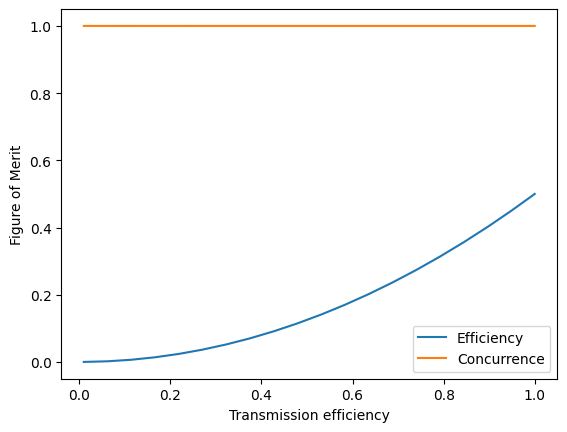

In [110]:
efficiency_list = [abs(4 * states[1, 1, 0, 0].tr()) for states in state_list] # multiply by 4 for all successful outcomes (assuming symmetry)
concurrence_list = [qt.concurrence(states[1, 1, 0, 0] / states[1, 1, 0, 0].tr()) for states in state_list]
plt.plot(transmission_list, efficiency_list, label='Efficiency')
plt.plot(transmission_list, concurrence_list, label='Concurrence')
plt.xlabel('Transmission efficiency')
plt.ylabel('Figure of Merit')
plt.legend()
plt.show()

As we can see, the concurrence produced using time-bin encoding is completely robust against losses. However, notably the protocol efficiency degrades much quicker than seen in the photon-number encoding. This is because it relies on the successful transmission of two photons rather than one.

## Polarization encoding

The final encoding we will explore is the polarization of light. Using the same trion source, we can exploit the fact that there are two orthogonally-polarized transitions that connect the ground-state spin doublet to the excited-state trion doublet. Instead of targeting just the R-polarized transition, we can instead excite both R and L polarized transition by using an H-polarized pulse. Then, if we begin with a spin superposition state $|\psi\rangle = (|\downarrow\rangle + |\uparrow\rangle)/\sqrt{2}$, after the trion state decays back to the ground state we will be left with the spin-polarization entangled state: $|\psi\rangle = (|\downarrow\rangle|L\rangle| + |\uparrow\rangle|R\rangle)/\sqrt{2}$. By interfering two such states on a beam splitter and monitoring the subsequent polarization at the output, we can identify that the case where we detect exactly one R and one L polarized photon will project the emitters onto a maximally entangled spin state.

The setup for this experiment is slightly less complicated than the time-bin encoding since we do not need to add a spin control pulse or create time bin detectors. Instead, we only need to use all 4 modes of our processor and configure the excitation pulse appropriately.

In [111]:
trion = Source.trion()
trion.initial_state = (trion.states['|spin_up>'] + trion.states['|spin_down>']) / np.sqrt(2)
trion.update_default_parameters({'theta': 0, 'phi': 0, # excitation polarization: horizontally  polarized.
                                 'theta_c': np.pi/4, 'phi_c': -np.pi/2, # collect polarization: right mode 0 (left for mode 1)
                                 'area': np.sqrt(2) * np.pi})  # pulse area of sqrt(2)*pi to bring both spin up and spin down state fully to the trion state

With our source configured, we can construct the setup. This time, we must add a detector for each spatial mode and each polarization for 4 detectors total.

In [112]:
p_pol = Processor() // ([0, 2], trion) // Circuit.loss(modes=4, name='transmission') // entangling_circuit // (list(range(4)), Detector.pnr(resolution=2))
p_pol.probs().display()

Pattern | Probability
2 0 0 0 | 0.12500
0 0 2 0 | 0.12500
1 1 0 0 | 0.12500
0 1 1 0 | 0.12500
0 2 0 0 | 0.12500
1 0 0 1 | 0.12500
0 0 1 1 | 0.12500
0 0 0 2 | 0.12500



Since our source modes are ordered (L, R), and the circuit does not permute them, the outputs of the processor are labelled following (L, R, L, R). We can always label the bins explicitly to be sure, or it is often possible to deduce the right labels by through experimental observation. Similar to the time-bin encoding, we can see that we only observe two-photon outputs, and since we expect to generate entanglement heralded by one of these, this protocol is also robust against loss. Let's confirm that we find entanglement.

In [113]:
states = p_pol.conditional_states(select=[1, 3])
for pattern, state in states.items():
    print(pattern, qt.concurrence(state / state.tr()))

(0, 0, 0, 2) 0
(0, 0, 1, 1) 0.9999993017264965
(0, 0, 2, 0) 0
(0, 1, 1, 0) 0.9999954728823505
(0, 2, 0, 0) 0
(1, 0, 0, 1) 0.9999925262768165
(1, 1, 0, 0) 0.9999987846232194
(2, 0, 0, 0) 0


As anticipated, we find a maximally entangled spin state when we observe an L and R photon. As with the other two schemes, we can

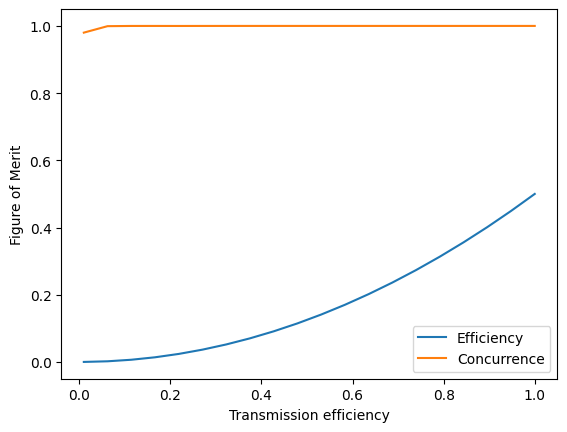

In [114]:
transmission_list = np.linspace(0.01, 1, 20)
state_list = [p_pol.conditional_states(parameters={'transmission/efficiency': eff}, select=[1, 3]) for eff in transmission_list]
efficiency_list = [abs(4 * states[1, 1, 0, 0].tr()) for states in state_list] # multiply by 4 for all successful outcomes (assuming symmetry)
concurrence_list = [qt.concurrence(states[1, 1, 0, 0] / states[1, 1, 0, 0].tr()) for states in state_list]
plt.plot(transmission_list, efficiency_list, label='Efficiency')
plt.plot(transmission_list, concurrence_list, label='Concurrence')
plt.xlabel('Transmission efficiency')
plt.ylabel('Figure of Merit')
plt.legend()
plt.show()

Unsurprisingly, since this protocol is also a two-photon protocol, it has an identical dependence on loss as the time-bin encoding.

## Comparison


Now that we have constructed the processors implementing each of the three protocols, and tested their basic features, we are in a good position to compare them. Since we already discussed losses, let's now take a look at emitter pure dephasing. Since the TrionEmitter class already has this parameter built in, all we need to do is modify it when running our protocol.

First thing we need to do is reset the initial state of the trion emitters in the photon-number encoding processor because we had modified it before.

In [115]:
trion_num.initial_state = (trion.states['|spin_up>'] + trion.states['|spin_down>']) / np.sqrt(2)

Now, let's find out how the concurrence depends on emitter pure dephasing for each protocol. Let's also compute the associated single-photon indistinguishability for the same dephasing rate.

In [116]:
dephasing_rates = np.linspace(0, 1, 10)
hom_list = []
concurrence_list_num = []
concurrence_list_time = []
concurrence_list_pol = []
for rate in dephasing_rates:
    hom_list.append(trion.hom(parameters={'dephasing': rate})['M'])

    state = p_num.conditional_states(parameters={'dephasing': rate}, select=[1, 3])[1, 0]
    concurrence_list_num.append(qt.concurrence(state / state.tr()))

    state = p_time.conditional_states(parameters={'dephasing': rate}, select=[1, 3])[1, 1, 0, 0]
    concurrence_list_time.append(qt.concurrence(state / state.tr()))

    state = p_pol.conditional_states(parameters={'dephasing': rate}, select=[1, 3])[1, 1, 0, 0]
    concurrence_list_pol.append(qt.concurrence(state / state.tr()))

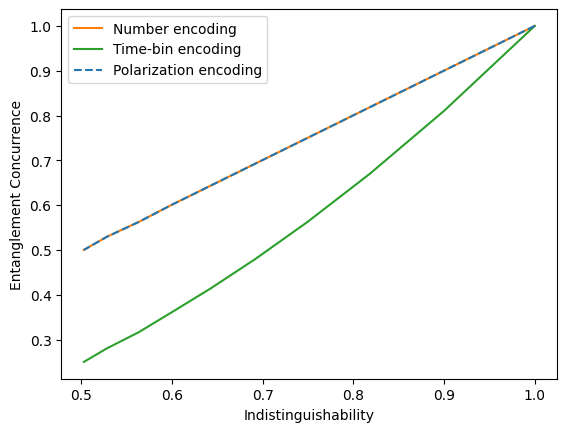

In [117]:
plt.plot(hom_list, concurrence_list_num, label='Number encoding', color='tab:orange')
plt.plot(hom_list, concurrence_list_time, label='Time-bin encoding', color='tab:green')
plt.plot(hom_list, concurrence_list_pol, label='Polarization encoding', color='tab:blue', linestyle='dashed')
plt.xlabel('Indistinguishability')
plt.ylabel('Entanglement Concurrence')
plt.legend()
plt.show()

Interestingly, we can clearly see that the time-bin encoding suffers substantially more from emitter pure dephasing than the other two protocols. This is because each source undergoes two excitation-decay cycles. The photon-number encoding only requires a single excitation that produces on average 1/2 of a photon, while the polarization encoding only requires a single excitation that produces on average 1 photon. So, although the number encoding and the polarization encoding use a different number of photons in total, it is the number of emitter cycles-not the total number of photons-that determines the susceptibility to emitter dephasing.